# Data Modelling Lab Project 
**Topic:** Neural Machine Translation

**Name:** Srinithi S L

**SC Code:** SC25M168

**Course:** Data Modelling Lab 

**Code Implementation in this file:** NMT Transformer Model Training

## Import Necessary Libraries 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import math
import re
import pickle
from collections import Counter
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Data Preprocessing and Tokenization

In [3]:
class Vocabulary:
    def __init__(self):
        self.word2idx = {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3}
        self.idx2word = {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>'}
        self.vocab_size = 4
    
    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.vocab_size
            self.idx2word[self.vocab_size] = word
            self.vocab_size += 1
    
    def build_vocab(self, sentences, min_count=2):
        word_counts = Counter()
        for sentence in sentences:
            word_counts.update(sentence.split())
        
        for word, count in word_counts.items():
            if count >= min_count:
                self.add_word(word)
        
        print(f"Vocabulary size: {self.vocab_size}")

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [4]:
def tokenize_and_build_vocab(data_path):
    df = pd.read_csv(data_path)
    print(f"dataset shape: {df.shape}")
    print(f"columns: {df.columns.tolist()}")
    eng_col = df.columns[0]
    fr_col = df.columns[1]
    eng_sentences = [preprocess_text(str(sent)) for sent in df[eng_col].values]
    fr_sentences = [preprocess_text(str(sent)) for sent in df[fr_col].values]
    valid_pairs = [(eng, fr) for eng, fr in zip(eng_sentences, fr_sentences) if len(eng.strip()) > 0 and len(fr.strip()) > 0]
    eng_sentences = [pair[0] for pair in valid_pairs]
    fr_sentences = [pair[1] for pair in valid_pairs]
    print(f"Valid sentence pairs: {len(valid_pairs)}")
    eng_vocab = Vocabulary()
    fr_vocab = Vocabulary()
    eng_vocab.build_vocab(eng_sentences)
    fr_vocab.build_vocab(fr_sentences)
    return eng_sentences, fr_sentences, eng_vocab, fr_vocab

In [5]:
class TranslationDataset(Dataset):
    def __init__(self, eng_sentences, fr_sentences, eng_vocab, fr_vocab, max_len=50):
        self.eng_sentences = eng_sentences
        self.fr_sentences = fr_sentences
        self.eng_vocab = eng_vocab
        self.fr_vocab = fr_vocab
        self.max_len = max_len
    
    def __len__(self):
        return len(self.eng_sentences)
    
    def sentence_to_indices(self, sentence, vocab, add_eos=True):
        indices = []
        for word in sentence.split():
            indices.append(vocab.word2idx.get(word, vocab.word2idx['<UNK>']))
        if add_eos:
            indices.append(vocab.word2idx['<EOS>'])
        if len(indices) > self.max_len:
            indices = indices[:self.max_len]
        else:
            indices.extend([vocab.word2idx['<PAD>']] * (self.max_len - len(indices)))
        return indices
    
    def __getitem__(self, idx):
        eng_sentence = self.eng_sentences[idx]
        fr_sentence = self.fr_sentences[idx]
        
        eng_indices = self.sentence_to_indices(eng_sentence, self.eng_vocab, add_eos=True)
        fr_input = [self.fr_vocab.word2idx['<SOS>']] + self.sentence_to_indices(fr_sentence, self.fr_vocab, add_eos=False)[:-1]
        fr_target = self.sentence_to_indices(fr_sentence, self.fr_vocab, add_eos=True)
        
        return {'english': torch.tensor(eng_indices, dtype=torch.long),'french_input': torch.tensor(fr_input, dtype=torch.long),
            'french_target': torch.tensor(fr_target, dtype=torch.long)}


## Model Architecture

In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
    def forward(self, x):
        return x + self.pe[:x.size(0), :]

In [7]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k) 
        if mask is not None:
            while mask.dim() < 4:
                mask = mask.unsqueeze(1) 
            if mask.size(-1) != scores.size(-1) or mask.size(-2) != scores.size(-2):
                if mask.size(-1) == scores.size(-1):
                    mask = mask.expand(scores.size(0), 1, scores.size(-2), scores.size(-1))
            scores = scores.masked_fill(mask == 0, -1e9)
        attention = F.softmax(scores, dim=-1)
        context = torch.matmul(attention, V)
        return context, attention
    
    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        Q = self.w_q(query).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        K = self.w_k(key).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        V = self.w_v(value).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)  
        context, attention = self.scaled_dot_product_attention(Q, K, V, mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        output = self.w_o(context)
        return output

In [8]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        return self.linear2(self.dropout(F.relu(self.linear1(x))))

In [9]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, n_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        
        return x

In [10]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, n_heads)
        self.cross_attn = MultiHeadAttention(d_model, n_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

In [11]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512, n_heads=8, n_layers=6, d_ff=2048, max_len=50):
        super(Transformer, self).__init__()
        self.d_model = d_model
        self.max_len = max_len
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, n_heads, d_ff) for _ in range(n_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, n_heads, d_ff) for _ in range(n_layers)])
        self.output_projection = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(0.1)
        
    def create_padding_mask(self, seq, pad_idx=0):
        mask = (seq != pad_idx).float()
        return mask.unsqueeze(1).unsqueeze(1)
    
    def create_look_ahead_mask(self, size, device):
        mask = torch.tril(torch.ones((size, size), device=device))
        return mask.unsqueeze(0).unsqueeze(0)
    
    def forward(self, src, tgt):
        batch_size, src_len = src.size()
        tgt_len = tgt.size(1)
        src_mask = self.create_padding_mask(src).to(src.device)
        tgt_padding_mask = self.create_padding_mask(tgt).to(tgt.device)
        tgt_look_ahead_mask = self.create_look_ahead_mask(tgt_len, tgt.device)
        tgt_mask = tgt_padding_mask * tgt_look_ahead_mask
        src_emb = self.dropout(self.pos_encoding(self.src_embedding(src) * math.sqrt(self.d_model)))
        tgt_emb = self.dropout(self.pos_encoding(self.tgt_embedding(tgt) * math.sqrt(self.d_model)))
        enc_output = src_emb
        for layer in self.encoder_layers:
            enc_output = layer(enc_output, src_mask)
        dec_output = tgt_emb
        for layer in self.decoder_layers:
            dec_output = layer(dec_output, enc_output, src_mask, tgt_mask)
        output = self.output_projection(dec_output)
        return output

## Training and Evaluation Function

In [12]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    
    for batch in tqdm(dataloader, desc="Training"):
        src = batch['english'].to(device)
        tgt_input = batch['french_input'].to(device)
        tgt_output = batch['french_target'].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(src, tgt_input)
        loss = criterion(outputs.reshape(-1, outputs.size(-1)), tgt_output.reshape(-1))
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

In [13]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            src = batch['english'].to(device)
            tgt_input = batch['french_input'].to(device)
            tgt_output = batch['french_target'].to(device)
            outputs = model(src, tgt_input)
            loss = criterion(outputs.reshape(-1, outputs.size(-1)), tgt_output.reshape(-1))
            total_loss += loss.item()
    return total_loss / len(dataloader)

In [14]:
def main():
    eng_sentences, fr_sentences, eng_vocab, fr_vocab = tokenize_and_build_vocab('eng_-french.csv')
    eng_train, eng_test, fr_train, fr_test = train_test_split(eng_sentences, fr_sentences, test_size=0.2, random_state=42)
    
    print(f"Training samples: {len(eng_train)}")
    print(f"Testing samples: {len(eng_test)}")
    
    train_dataset = TranslationDataset(eng_train, fr_train, eng_vocab, fr_vocab)
    test_dataset = TranslationDataset(eng_test, fr_test, eng_vocab, fr_vocab)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    model = Transformer(src_vocab_size=eng_vocab.vocab_size,tgt_vocab_size=fr_vocab.vocab_size, d_model=512,n_heads=8,n_layers=6,d_ff=2048).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
    criterion = nn.CrossEntropyLoss(ignore_index=fr_vocab.word2idx['<PAD>'])
    print("\nTraining the Model")
    train_losses = []
    test_losses = []
    
    for epoch in range(5):
        print(f"\nEpoch {epoch+1}/5")
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        train_losses.append(train_loss)
        
        test_loss = evaluate(model, test_loader, criterion, device)
        test_losses.append(test_loss)
        
        print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
    
    # Save model and vocabularies
    save_dict = {'model_state_dict': model.state_dict(),'eng_vocab': eng_vocab,'fr_vocab': fr_vocab,
        'model_config': {'src_vocab_size': eng_vocab.vocab_size,'tgt_vocab_size': fr_vocab.vocab_size,'d_model': 512,'n_heads': 8,'n_layers': 6,
                        'd_ff': 2048,'max_len': 50}}
    
    torch.save(save_dict, 'nmt_transformer_model.pth')
    print("\nModel saved as 'nmt_transformer_model.pth'")
    
    # Plot training curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    plt.savefig('training_curve.png')
    plt.show()
    
    print("Training is Completed and the model is saved")

dataset shape: (175621, 2)
columns: ['English words/sentences', 'French words/sentences']
Valid sentence pairs: 175621
Vocabulary size: 10003
Vocabulary size: 17973
Training samples: 140496
Testing samples: 35125

Training the Model

Epoch 1/5


Evaluating: 100%|██████████████████████████████████████████████████████████████████| 1098/1098 [01:20<00:00, 13.72it/s]


Train Loss: 3.4284, Test Loss: 2.5281

Epoch 2/5


Evaluating: 100%|██████████████████████████████████████████████████████████████████| 1098/1098 [01:16<00:00, 14.35it/s]


Train Loss: 2.2760, Test Loss: 2.0915

Epoch 3/5


Evaluating: 100%|██████████████████████████████████████████████████████████████████| 1098/1098 [01:52<00:00,  9.78it/s]


Train Loss: 1.8995, Test Loss: 1.8946

Epoch 4/5


Evaluating: 100%|██████████████████████████████████████████████████████████████████| 1098/1098 [01:59<00:00,  9.19it/s]


Train Loss: 1.6777, Test Loss: 1.7963

Epoch 5/5


Evaluating: 100%|██████████████████████████████████████████████████████████████████| 1098/1098 [01:18<00:00, 13.99it/s]


Train Loss: 1.5206, Test Loss: 1.7317

Model saved as 'nmt_transformer_model.pth'


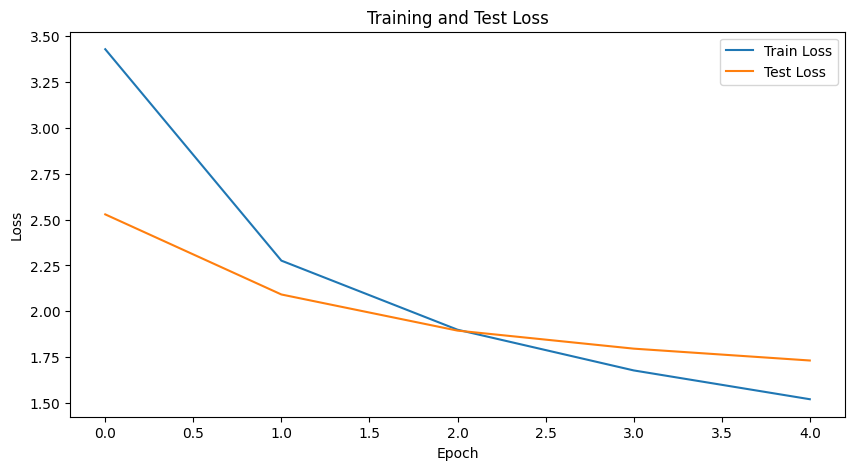

Training is Completed and the model is saved


In [15]:
main()